#Data Engineering with Pandas: Part 2
Best Practices with Matt Harrison
https://www.youtube.com/watch?v=zgbUk90aQ6A 

Chaining is also called "flow programming." Rather than making intermediate variables, rely on each pandas method to return an object on which the next operation performs.

If chaining is not possible, use pandas.pipe() and add functions to the recipe that transform the input and return the object that you need to continue.

###Outline
* Debugging a Flow
  - Write intermediate state to var 
  - Use .pipe to display intemediate state
* Avoiding Data Mutation
* Avoiding apply with numerals, if possible
* Using apply, where, and isin with strings
* Aggregation

##Load Data


In [ ]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd

In [ ]:
pd.__version__

'1.3.5'

In [ ]:
pd.options.display.min_rows = 20

In [ ]:
autos = pd.read_csv('https://github.com/mattharrison/datasets/raw/master/data/vehicles.csv.zip')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (68,70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
autos.head()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,...,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.0,Rear-Wheel Drive,9011,(FFS),-1,2000,0,Regular,Regular Gasoline,-1,-1,25,0.0,0,0.0,0.0,0.0,...,1,0,0,Alfa Romeo,Spider Veloce 2000,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,23.3333,0.0,35.0000,0.0,Two Seaters,1985,-2250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,29.964545,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,12.0,4.9,Rear-Wheel Drive,22020,(GUZZLER),-1,3850,0,Regular,Regular Gasoline,-1,-1,14,0.0,0,0.0,0.0,0.0,...,10,0,0,Ferrari,Testarossa,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,11.0000,0.0,19.0000,0.0,Two Seaters,1985,-11500,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,12.207778,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,329.148148,27,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,2100,(FFS),-1,1550,0,Regular,Regular Gasoline,-1,-1,33,0.0,0,0.0,0.0,0.0,...,100,0,0,Dodge,Charger,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,29.0000,0.0,47.0000,0.0,Subcompact Cars,1985,0,NaN,SIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
3,29.964545,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8.0,5.2,Rear-Wheel Drive,2850,NaN,-1,3850,0,Regular,Regular Gasoline,-1,-1,12,0.0,0,0.0,0.0,0.0,...,1000,0,0,Dodge,B150/B250 Wagon 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,12.2222,0.0,16.6667,0.0,Vans,1985,-11500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
4,17.347895,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,467.736842,19,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66031,"(FFS,TRBO)",-1,2700,0,Premium,Premium Gasoline,-1,-1,23,0.0,0,0.0,0.0,0.0,...,10000,0,14,Subaru,Legacy AWD Turbo,N,False,0,90,0,0.0,0.0,0.0,0.0,Manual 5-spd,21.0000,0.0,32.0000,0.0,Compact Cars,1993,-5750,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [ ]:
autos.shape

(41144, 83)

##Debugging a Flow
An objection to flow programming is that the lack of state makes it difficult to debug.

Approaches:
* Assign intermediate states to vars for inspection
* Comment out line by line and run to see step-wise results
* Pipe intermediate states to iPython displays

In [ ]:
#Create a function that captures the current state of a dataframe
#at any moment in the flow and saves it to a global variable. 
def get_var(df, var_name):
  globals()[var_name] = df
  return df

def prep_autos(autos):
  #Define the columns of interest.
  cols_subset = ['city08','comb08','highway08','cylinders',
                'displ','drive','eng_dscr','fuelCost08','make',
                'model','range','trany','createdOn','year']
  
  #Return the transformed dataset.
  return (autos
          [cols_subset]
          .pipe(get_var, 'df3')
          .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
                  displ=autos.displ.fillna(0).astype('float16'),
                  drive=autos.drive.fillna('Other').astype('category'),
                  #automatic will be boolean evaluation with str.contains.
                  automatic=autos.trany.str.contains('Auto'),
                  #speed will be string digit extracted with regex and converted to integer
                  speed = autos.trany.str.extract(r'(\d)+').fillna('4').astype('int8'),
                  #the date column needs to be converted to datetime format. Use .replace in response to warnings.
                  createdOn = pd.to_datetime(autos.createdOn.replace(
                      {' EDT':'-04:00',' EST':'-05:00'},regex=True)),
                  #ffs will be boolean with str.contains('FFS')
                  ffs = autos.eng_dscr.str.contains('FFS')
                  ) #END assign
          #Return intermediate state and keep the chain alive.
          #.pipe(lambda df: display(df) or df)
          .astype({'highway08':'int8','city08':'int16','comb08':'int16',
                    'fuelCost08':'int16','range':'int16','year':'int16', 'make': 'category'})
          .drop(columns=['trany','eng_dscr'])
  )

In [ ]:
autos_prepped = prep_autos(autos)

In [ ]:
#Inspect state captured in df3
df3.head()

,city08,comb08,highway08,cylinders,displ,drive,eng_dscr,fuelCost08,make,model,range,trany,createdOn,year
0,19,21,25,4.0,2.0,Rear-Wheel Drive,(FFS),2000,Alfa Romeo,Spider Veloce 2000,0,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013,1985
1,9,11,14,12.0,4.9,Rear-Wheel Drive,(GUZZLER),3850,Ferrari,Testarossa,0,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013,1985
2,23,27,33,4.0,2.2,Front-Wheel Drive,(FFS),1550,Dodge,Charger,0,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013,1985
3,10,11,12,8.0,5.2,Rear-Wheel Drive,NaN,3850,Dodge,B150/B250 Wagon 2WD,0,Automatic 3-spd,Tue Jan 01 00:00:00 EST 2013,1985
4,17,19,23,4.0,2.2,4-Wheel or All-Wheel Drive,"(FFS,TRBO)",2700,Subaru,Legacy AWD Turbo,0,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013,1993


##Avoiding Mutations
inplace=True inplace does not generally do anything inplace but makes a copy and reassigns the pointer. You may think you are saving memory, but you are not. 

Moreover, mutating code is much harder to debug (not to mention more complicated to support actual inplace ops). 

Source: jreback, Pandas core dev: https://github.com/pandas-dev/pandas/issues/16529

inplace=True:
* No performance benefits, generally
* Prohibits chaining
* SettingWithCopyWarning fun
* In functions, inplace=True returns None

Example: if drop(columns=['a','b'], inplace=True), then the function returns none.

## Avoid Apply, if possible
The overhead is substantial: it takes each value from a series, converts it to a python object, performs the operation, and converts it back to a pandas object.

Experiments show that simpler mathematical expressions finish in microseconds what apply finishes in milliseconds, a difference of 10x faster.

In [ ]:
#EXPERIMENT 1: Calculation
#Scenario: you want to convert mpg to European liters per 100 kilometers.
#Approach: Using apply with a function.
def to_ltrper100km(val):
  return 235.215/val
#This function, applied to a series, returns
#the conversion for each val in series.

In [ ]:
#Approach 1: Using apply
%%timeit
autos_prepped.city08.apply(to_ltrper100km)

100 loops, best of 5: 9.77 ms per loop


In [ ]:
#Approach 2: Using a simple mathematical expression that 
#leverages CPU architecture.
%%timeit
235.215/autos_prepped.city08

1000 loops, best of 5: 214 µs per loop


In [ ]:
#EXPERIMENT 2: Search and Match Strings
def is_american(val):
  return val in {'Chevrolet','Ford','Dodge','GMC','Tesla'}

In [ ]:
%%timeit
autos_prepped.make.apply(is_american)

The slowest run took 5.07 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1.3 ms per loop


In [ ]:
%%timeit
autos_prepped.make.isin({'Chevrolet','Ford','Dodge','GMC','Tesla'})

1000 loops, best of 5: 946 µs per loop


NOTE: strings in Python are treated as objects, not vectorized, and so they are slow by default. Nonethless, using isin() with categorical data type (instead of str) optimizes best. 

FWIW, the categorical data type converts entries to integers (behind the scenes) and maps them back to a single string representation. Great for low cardinality columns. 

In [ ]:
#EXPERIMENT 3: Derive Data (Create New Columns)
#Derived data relies on assign to create a new from an existing column. 
def country(val):
  if val in {'Chevrolet','Ford','Dodge','GMC','Tesla'}:
    return 'US'
  return 'Other'

In [ ]:
#APPROACH 1: Using apply with function
%%timeit
(autos_prepped
 .assign(country=autos_prepped.make.apply(country))
 )

100 loops, best of 5: 2.83 ms per loop


In [ ]:
#APPROACH 2: Using where instead of apply
%%timeit
values = {'Chevrolet','Ford','Dodge','GMC','Tesla'}
(autos_prepped
 .assign(country='US')
 .assign(country=lambda df_: df_.country.where(df_.make.isin(values),'Other'))
 )

100 loops, best of 5: 8.17 ms per loop


NOTE: no gain with 'where' versus 'apply' when working with strings. Gains come when working with numbers that pandas/numpy can vectorize.

Numpy has a select method that can work too.

In [ ]:
#APPROACH 3: Using np.select([expression],['a'],'b')
%%timeit
values = {'Chevrolet','Ford','Dodge','GMC','Tesla'}
(autos_prepped
.assign(country=np.select([autos_prepped.make.isin(values)],
                          ['US'],'Other'))    
)

100 loops, best of 5: 6.62 ms per loop


In [ ]:
#APPROACH 4: Using np.where(expression,'a','b')
%%timeit
values = {'Chevrolet','Ford','Dodge','GMC','Tesla'}
(autos_prepped
 .assign(country=np.where(autos_prepped.make.isin(values),'US','Other'))
)

100 loops, best of 5: 6.38 ms per loop


##Mastering Aggregation
Comparing mileage by country by year...

In [ ]:
#Give me the average by year. 
(autos_prepped
 .groupby('year')
 .mean()
 .head()
 )
#Returns all columns in one row per year.

,city08,comb08,highway08,cylinders,displ,fuelCost08,range,speed
year,,,,,,,,
1984,17.982688,19.881874,23.075356,5.385438,3.164062,2313.543788,0.0,3.911914
1985,17.878307,19.808348,23.042328,5.375661,3.164062,2334.509112,0.0,3.924750
1986,17.665289,19.550413,22.699174,5.425620,3.183594,2354.049587,0.0,3.984298
1987,17.310345,19.228549,22.445068,5.412189,3.173828,2403.648757,0.0,4.037690
1988,17.333628,19.328319,22.702655,5.461947,3.195312,2387.035398,0.0,4.129204


In [ ]:
#Give me the average of mpg and speeds by year.
(autos_prepped
 .groupby(['year'])
 [['comb08','speed']]
 .mean()
 .head()
 )

,comb08,speed
year,,
1984,19.881874,3.911914
1985,19.808348,3.924750
1986,19.550413,3.984298
1987,19.228549,4.037690
1988,19.328319,4.129204


In [ ]:
#Don't ask for calculations you don't need.
%%timeit
(autos_prepped
 .groupby('year')
 .mean() #Why calc mean of all, when you only need two?
 [['comb08','speed']]
 .head()
 )

100 loops, best of 5: 7.14 ms per loop


In [ ]:
#Be careful of operations order.
%%timeit
(autos_prepped
 .groupby('year')
 [['comb08','speed']]
 .mean()
 .head()
 )

100 loops, best of 5: 3.24 ms per loop


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

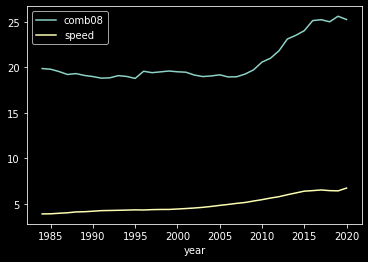

In [ ]:
#Normal plot is a line. Index is x-axis and each column is a line. 
(autos_prepped
 .groupby('year')
 [['comb08','speed']]
 .mean()
 #.median()
 #.quantile(.1)
 .plot()
 )

In [ ]:
#Grouping with two levels
(autos_prepped
 .assign(country=autos_prepped.make.apply(country))
 .groupby(['year','country'])
 .mean()
 .head(10)
 )

city08     comb08  highway08  ...   fuelCost08  range     speed
year country                                   ...                              
1984 Other    19.384615  21.417330  24.847038  ...  2118.125553    0.0  3.969054
     US       16.079232  17.797119  20.669868  ...  2578.871549    0.0  3.834334
1985 Other    19.284768  21.373068  24.816777  ...  2141.997792    0.0  3.958057
     US       16.275472  18.025157  21.020126  ...  2553.899371    0.0  3.886792
1986 Other    19.167183  21.213622  24.650155  ...  2149.148607    0.0  4.069659
     US       15.945035  17.645390  20.464539  ...  2588.741135    0.0  3.886525
1987 Other    18.633381  20.710414  24.186876  ...  2227.318117    0.0  4.142653
     US       15.611722  17.326007  20.208791  ...  2630.036630    0.0  3.902930
1988 Other    18.668224  20.814642  24.437695  ...  2207.476636    0.0  4.205607
     US       15.577869  17.372951  20.420082  ...  2623.258197    0.0  4.028689

[10 rows x 8 columns]

In [ ]:
#Asking for multiple aggregations and custom aggregations
#Find the second to last value in a series. 
def second_to_last(ser):
  return ser.iloc[-2]

In [ ]:
#Hierarchical rows and columns.
(autos_prepped
 .assign(country=autos_prepped.make.apply(country))
 .groupby(['year','country'])
 .agg(['max','mean',second_to_last,'min'])
 .head(10)
 )

city08                            ...       ffs                      
                max       mean second_to_last  ...      mean second_to_last    min
year country                                   ...                                
1984 Other       38  19.384615             14  ...  0.714554           True  False
     US          35  16.079232             15  ...  0.638801            NaN  False
1985 Other       40  19.284768             19  ...  0.889160           True  False
     US          39  16.275472             14  ...  0.851351            NaN  False
1986 Other       42  19.167183             10  ...  0.934211            NaN  False
     US          44  15.945035             16  ...  0.795699            NaN  False
1987 Other       42  18.633381             12  ...  0.949778           True  False
     US          44  15.611722             12  ...  0.909457           True  False
1988 Other       41  18.668224             12  ...  0.993681           True  False
     US          44  15.577869             14  ...  0.936306           True  False

[10 rows x 40 columns]

In [ ]:
#If you need to plot a table with a stacked index, unstack it.
(autos_prepped
 .assign(country=autos_prepped.make.apply(country))
 .groupby(['year','country'])
 .mean()
 .unstack()
 .head()
 #.plot()
 )

city08                comb08  ... range     speed          
country      Other         US      Other  ...    US     Other        US
year                                      ...                          
1984     19.384615  16.079232  21.417330  ...   0.0  3.969054  3.834334
1985     19.284768  16.275472  21.373068  ...   0.0  3.958057  3.886792
1986     19.167183  15.945035  21.213622  ...   0.0  4.069659  3.886525
1987     18.633381  15.611722  20.710414  ...   0.0  4.142653  3.902930
1988     18.668224  15.577869  20.814642  ...   0.0  4.205607  4.028689

[5 rows x 16 columns]

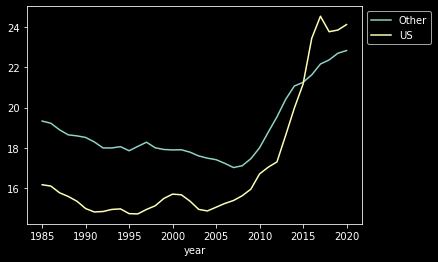

In [ ]:
#If you need to plot a table with a stacked index, unstack it, then specity
#which column by chaining the column name.
(autos_prepped
 .assign(country=autos_prepped.make.apply(country))
 .groupby(['year','country'])
 .mean()
 .unstack()
 .city08
 #To smooth a jagged curve, take a rolling average and the mean of that.
 .rolling(2)
 .mean()
 #.head()
 .plot()
 .legend(bbox_to_anchor=(1,1))
 )

In [ ]:
#What is the pandas equlivalent of sql groupby having?
#A common example creates a grouped intermediate variable, 
#then applies filter with a condition.
 
# data = pandas.DataFrame({'Student Name' : ['Anil', 'Musk','Bill'], 
#                         'Class' : [1,2,2], 
#                         'Age' : [6, 7, 8 ]})
# output = data.groupby(data["Class"])
# output.filter(lambda g: len(g) > 1)

In [ ]:
#In pandas, there are simple arithmetic comparators: equals, gt, lt, etc.
#Or you can use .pipe(expression) and define a function that applies a condition.
def greater_than(df_, num):
  return df_[df_.gt(num)].dropna()

(autos_prepped[['make','model']]
 .assign(country=autos_prepped.make.apply(country))
 .groupby(['country','make'])
 .count()
 .pipe(greater_than,10)
 .head(20)
 )

model
country make                               
Other   Acura                         347.0
        Alfa Romeo                     62.0
        American Motors Corporation    27.0
        Aston Martin                  156.0
        Audi                         1002.0
        BMW                          1966.0
        Bentley                       127.0
        Buick                         667.0
        CX Automotive                  17.0
        Cadillac                      583.0
        Chrysler                      726.0
        Daewoo                         67.0
        Daihatsu                       17.0
        Eagle                         161.0
        Federal Coach                  14.0
        Ferrari                       229.0
        Fiat                           71.0
        Genesis                        43.0
        Geo                           147.0
        Honda                        1001.0